<a href="https://colab.research.google.com/github/robert-shepherd/fpl/blob/main/Project_2_exploratory_analysis_and_feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exploratory analysis and data preparation


---

The purpose of this script is to explore the historic data and define new features before modelling

Data sources:
* Combined data: https://raw.githubusercontent.com/robert-shepherd/fpl/main/fpl_combined_data.csv

Output:
* Data is downloaded and subsequently saved to: https://raw.githubusercontent.com/robert-shepherd/fpl/main/fpl_combined_data.csv


In [36]:
# Installing manual packages
!pip install pingouin # Used to calculate partial correlation

In [37]:
# Loading libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import files
import missingno as msno
from scipy.stats import entropy
import pingouin as pg

In [38]:
#Setting default Seaborn style
sns.set(rc={'figure.figsize':(10,8)})

## Reading in data

In [39]:
# Read in data
url = 'https://raw.githubusercontent.com/robert-shepherd/fpl/main/fpl_combined_data.csv'

df = pd.read_csv(url)

In [40]:
# Check data
df.head()

,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,round,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out,element_type,position,opponent_strength,season
0,402,5,12,0,False,2018-08-12T12:30:00Z,4.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,55,0,103396,0,0,2,DEF,5,2018
1,402,250,12,2,True,2019-02-04T20:00:00Z,1.0,1.0,25,90,0,0,0,1,0,0,0,0,0,0,0,7,7.6,0.6,10.0,1.8,50,-787,32970,27,814,2,DEF,5,2018
2,145,15,12,-2,True,2018-08-20T19:00:00Z,0.0,2.0,2,74,0,0,0,2,0,0,0,0,1,0,0,-1,12.4,12.3,4.0,2.9,41,282492,1110097,296156,13664,2,DEF,5,2018
3,145,225,12,0,False,2019-01-19T15:00:00Z,4.0,3.0,23,90,0,0,0,4,0,0,0,0,0,0,0,15,17.8,0.8,0.0,1.9,45,21257,2025265,76053,54796,2,DEF,5,2018
4,386,128,12,1,True,2018-11-24T15:00:00Z,0.0,3.0,13,90,0,0,0,3,0,0,0,0,0,0,0,12,11.8,19.9,0.0,3.2,43,-768,6017,166,934,2,DEF,5,2018


In [41]:
# Check schema
df.dtypes

element                int64
fixture                int64
opponent_team          int64
total_points           int64
was_home                bool
kickoff_time          object
team_h_score         float64
team_a_score         float64
round                  int64
minutes                int64
goals_scored           int64
assists                int64
clean_sheets           int64
goals_conceded         int64
own_goals              int64
penalties_saved        int64
penalties_missed       int64
yellow_cards           int64
red_cards              int64
saves                  int64
bonus                  int64
bps                    int64
influence            float64
creativity           float64
threat               float64
ict_index            float64
value                  int64
transfers_balance      int64
selected               int64
transfers_in           int64
transfers_out          int64
element_type           int64
position              object
opponent_strength      int64
season        

## Understanding points behaviour

In [42]:
# Checking min and max
min_points = min(df.total_points)
max_points = max(df.total_points)
avg_points = np.mean(df.total_points)

print('Data ranges between',min_points,'and',max_points,'with an average of',avg_points)

Data ranges between -6 and 26 with an average of 1.402631318626966


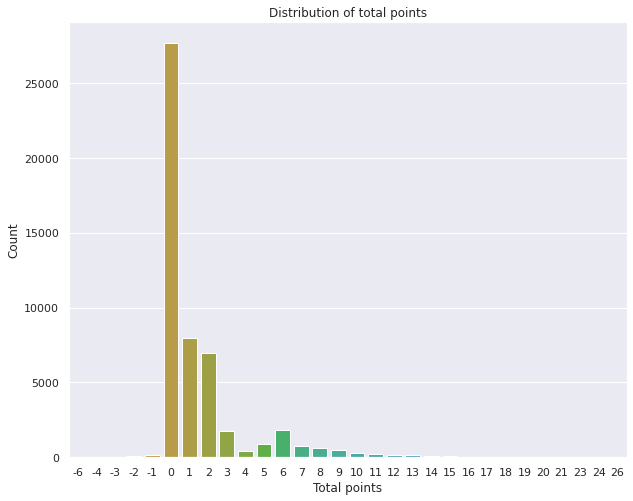

In [43]:
# Checking distribution
_ = sns.countplot(x=df.total_points)
_ = plt.xlabel('Total points')
_ = plt.ylabel('Count')
plt.title("Distribution of total points")
plt.show()

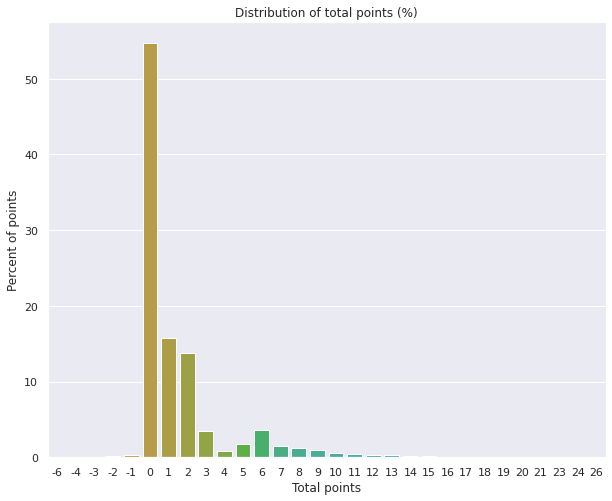

In [44]:
# Checking distribution (%)
_ = sns.barplot(x="total_points", y="total_points", data=df, estimator=lambda x: len(x) / len(df) * 100)
plt.xlabel('Total points')
plt.ylabel('Percent of points')
plt.title("Distribution of total points (%)")
plt.show()

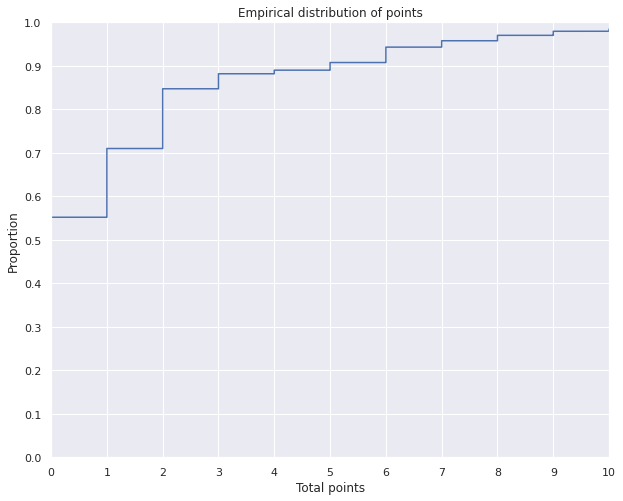

In [45]:
# Checking distribution (%)
xt = np.linspace(0,10,11)
yt = np.linspace(0,1,11)
_ = sns.ecdfplot(x="total_points", data=df)
_ = _.set(xlim=(0,10),
          xticks=xt,
          yticks=yt)
plt.xlabel('Total points')
plt.title("Empirical distribution of points")
plt.show()

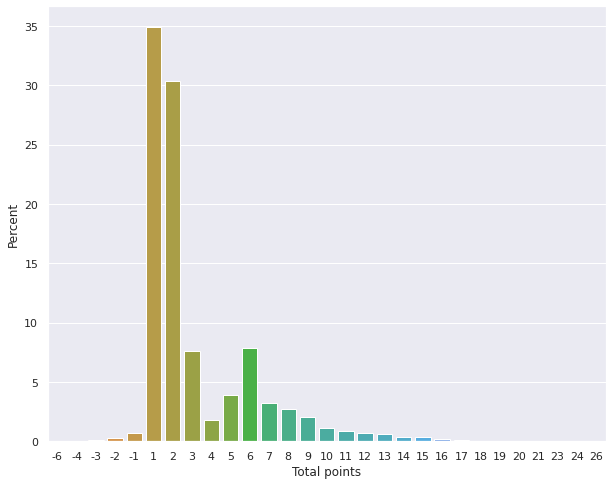

In [46]:
# Checking distribution with 0 removed(%)
df_no_0 = df[df.total_points!=0]
_ = sns.barplot(x="total_points", y="total_points", data=df_no_0, estimator=lambda x: len(x) / len(df_no_0) * 100)
_ = plt.xlabel('Total points')
_ = plt.ylabel('Percent')
plt.show()

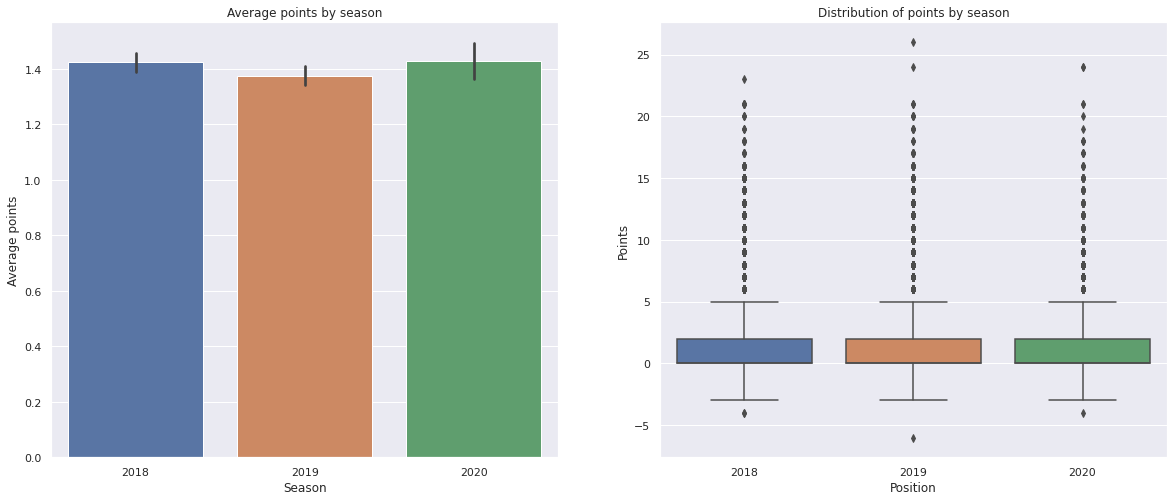

In [47]:
# Creating subplots
fig, ax = plt.subplots(1,2,figsize=(20,8))

# Checking if the average score changes by season
ax1 = sns.barplot(x="season", y="total_points", data=df, estimator=lambda x: sum(x) / len(x),ax=ax[0])
ax1.set_xlabel('Season')
ax1.set_ylabel('Average points')
ax1.set_title("Average points by season")

# Checking if the distribution changes by season
ax2 = sns.boxplot(x='season',y='total_points',data=df,ax=ax[1])
ax2.set_xlabel('Position')
ax2.set_ylabel('Points')
ax2.set_title("Distribution of points by season")

fig.show()

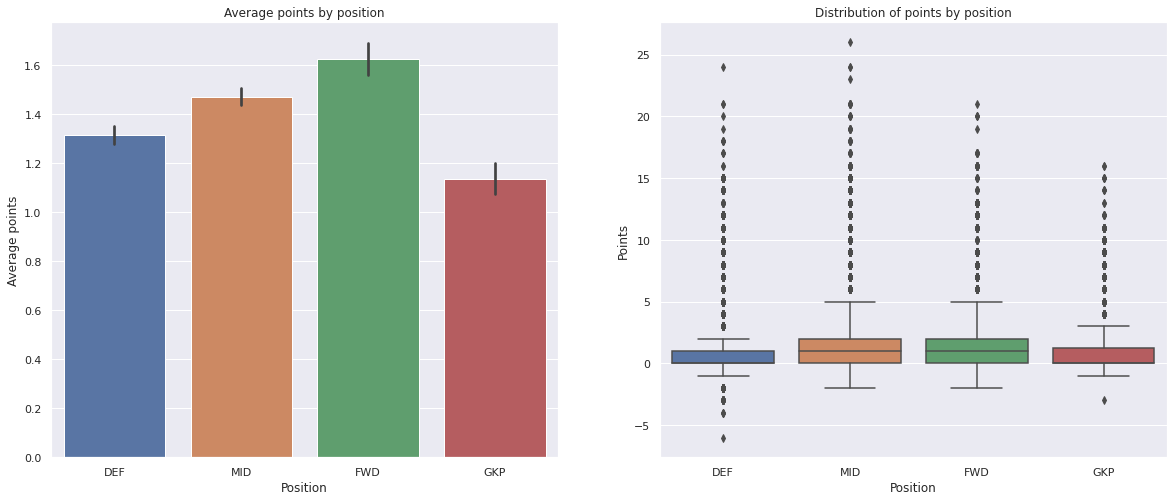

In [48]:
# Creating subplots
fig, ax = plt.subplots(1,2,figsize=(20,8))

# Checking if the average score changes by position
ax1 = sns.barplot(x="position", y="total_points", data=df, estimator=lambda x: sum(x) / len(x),ax=ax[0])
ax1.set_xlabel('Position')
ax1.set_ylabel('Average points')
ax1.set_title("Average points by position")

# Checking if the distribution changes by position
ax2 = sns.boxplot(x='position',y='total_points',data=df,ax=ax[1])
ax2.set_xlabel('Position')
ax2.set_ylabel('Points')
ax2.set_title("Distribution of points by position")

fig.show()


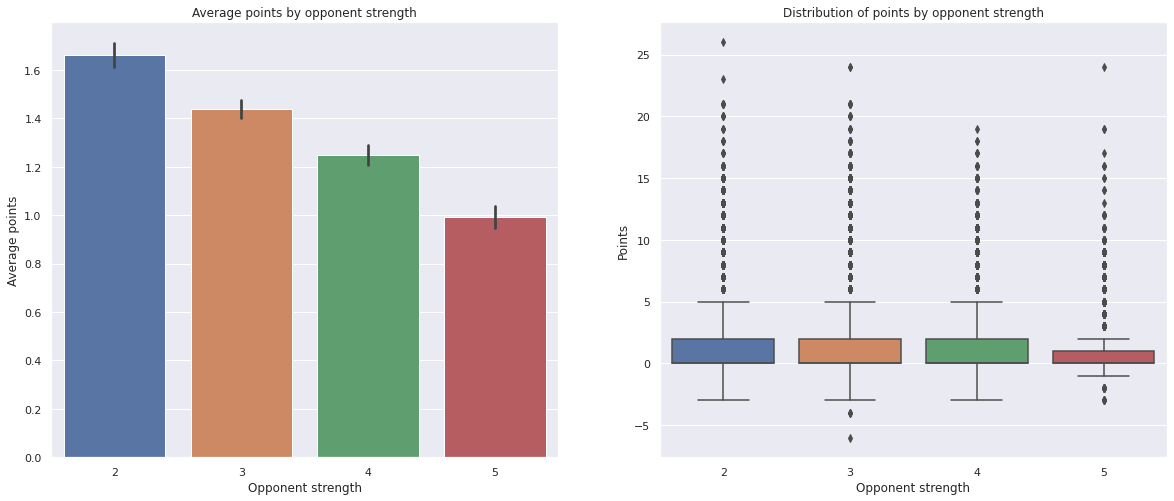

In [49]:
# Creating subplots
fig, ax = plt.subplots(1,2,figsize=(20,8))

# Checking if the average score changes by opponent strength
ax1 = sns.barplot(x="opponent_strength", y="total_points", data=df, estimator=lambda x: sum(x) / len(x),ax=ax[0])
ax1.set_xlabel('Opponent strength')
ax1.set_ylabel('Average points')
ax1.set_title("Average points by opponent strength")

# Checking if the distribution changes by opponent strength
ax2 = sns.boxplot(x='opponent_strength',y='total_points',data=df,ax=ax[1])
ax2.set_xlabel('Opponent strength')
ax2.set_ylabel('Points')
ax2.set_title("Distribution of points by opponent strength")

fig.show()

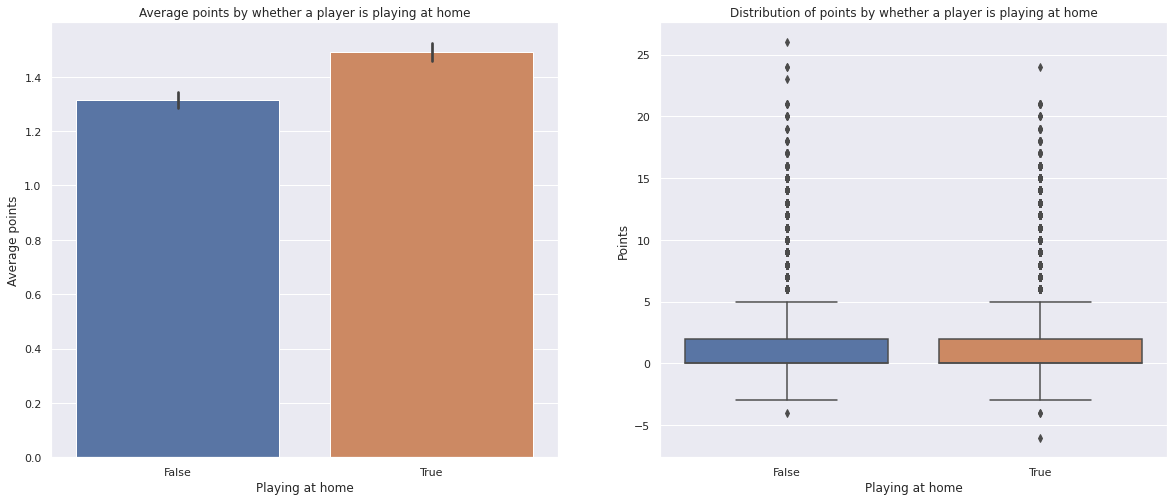

In [50]:
# Creating subplots
fig, ax = plt.subplots(1,2,figsize=(20,8))

# Checking if the average score changes by a player playing at home
ax1 = sns.barplot(x="was_home", y="total_points", data=df, estimator=lambda x: sum(x) / len(x),ax=ax[0])
ax1.set_xlabel('Playing at home')
ax1.set_ylabel('Average points')
ax1.set_title("Average points by whether a player is playing at home")

# Checking if the distribution changes by a player playing at home
ax2 = sns.boxplot(x='was_home',y='total_points',data=df,ax=ax[1])
ax2.set_xlabel('Playing at home')
ax2.set_ylabel('Points')
ax2.set_title("Distribution of points by whether a player is playing at home")

fig.show()

## Checking for missing data and anomalies

> Indented block



In [51]:
# Summarising data
df_describe = df.describe()
df_describe

,element,fixture,opponent_team,total_points,team_h_score,team_a_score,round,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out,element_type,opponent_strength,season
count,50545.000000,50545.000000,50545.000000,50545.000000,50486.000000,50486.000000,50545.000000,50545.000000,50545.000000,50545.000000,50545.000000,50545.000000,50545.000000,50545.000000,50545.000000,50545.000000,50545.000000,50545.000000,50545.000000,50545.000000,50545.000000,50545.000000,50545.000000,50545.000000,50545.000000,5.054500e+04,5.054500e+04,5.054500e+04,5.054500e+04,50545.000000,50545.000000,50545.000000
mean,293.383896,180.127965,10.501929,1.402631,1.525750,1.263043,19.588406,33.818182,0.046434,0.041883,0.105807,0.527965,0.001563,0.000752,0.000969,0.055752,0.002077,0.100425,0.109526,6.219171,7.605168,4.950284,5.631022,1.817594,51.696745,4.847860e+02,1.711493e+05,1.159178e+04,1.110644e+04,2.571867,3.192878,2018.691463
std,170.733612,113.303319,5.768017,2.546214,1.287602,1.212843,13.037342,40.875912,0.236541,0.218013,0.307593,0.987464,0.039504,0.028122,0.031121,0.229445,0.045531,0.648437,0.493942,9.845856,13.158089,10.906202,13.943259,3.108202,12.324473,5.108860e+04,3.986861e+05,4.427434e+04,3.790946e+04,0.859872,0.958301,0.677111
min,1.000000,1.000000,1.000000,-6.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-14.000000,0.000000,0.000000,0.000000,0.000000,38.000000,-1.347561e+06,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,2.000000,2018.000000
25%,146.000000,78.000000,6.000000,0.000000,1.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44.000000,-1.564000e+03,6.773000e+03,5.600000e+01,1.770000e+02,2.000000,2.000000,2018.000000
50%,292.000000,175.000000,10.000000,0.000000,1.000000,1.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.000000,-1.110000e+02,2.751300e+04,4.370000e+02,1.157000e+03,3.000000,3.000000,2019.000000
75%,439.000000,280.000000,16.000000,2.000000,2.000000,2.000000,29.000000,90.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,11.800000,3.100000,2.000000,2.600000,55.000000,3.900000e+01,1.318320e+05,4.152000e+03,7.004000e+03,3.000000,4.000000,2019.000000
max,669.000000,380.000000,20.000000,26.000000,8.000000,9.000000,47.000000,90.000000,4.000000,4.000000,1.000000,9.000000,1.000000,2.000000,1.000000,1.000000,1.000000,12.000000,3.000000,92.000000,144.000000,134.800000,181.000000,35.800000,136.000000,1.907229e+06,4.719468e+06,1.991731e+06,1.395400e+06,4.000000,5.000000,2020.000000


In [52]:
# Downloading a summary of the data to Excel to clean (commented out by default)
df_describe.to_csv('fpl_description.csv') 
# files.download('fpl_description.csv')

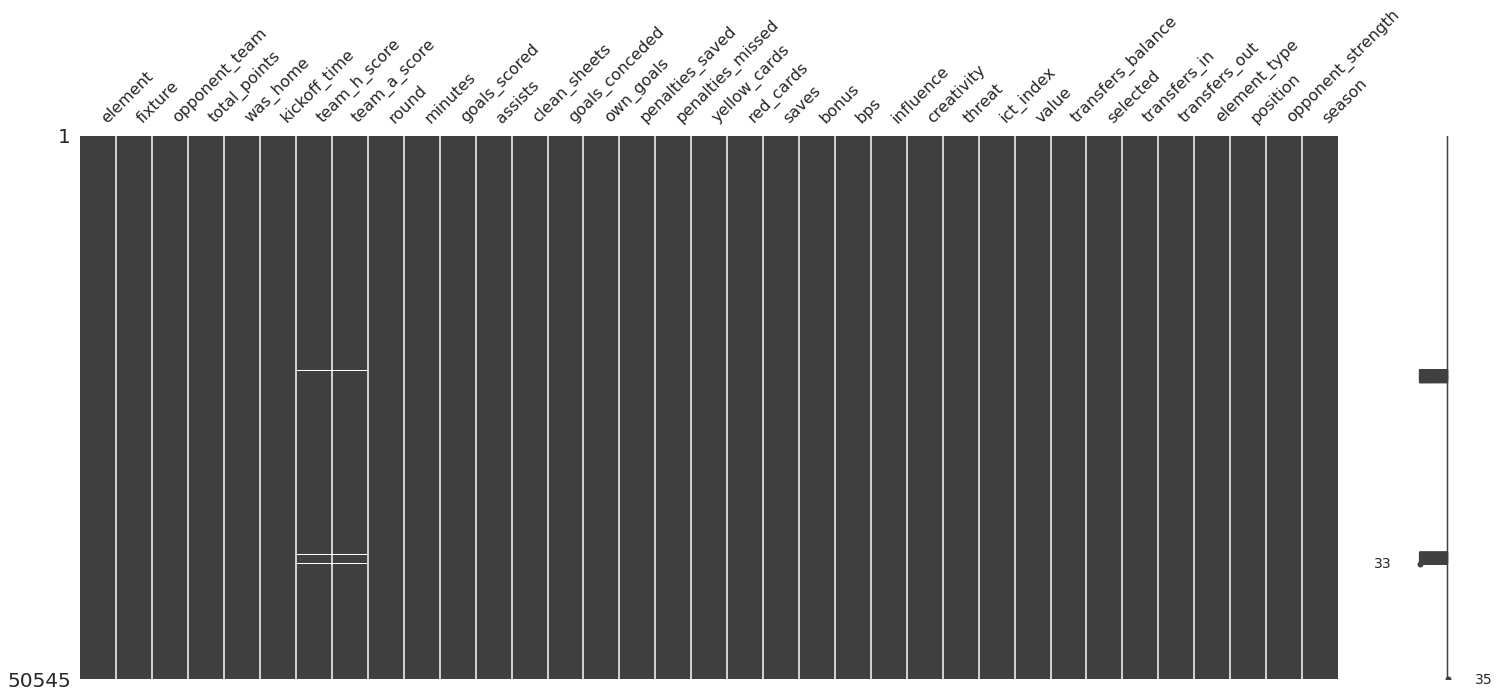

In [53]:
# Visualising missing data
_ = msno.matrix(df)

plt.show()

In [54]:
# Checking frequency of NA for each variable
df.isna().sum()

element               0
fixture               0
opponent_team         0
total_points          0
was_home              0
kickoff_time          0
team_h_score         59
team_a_score         59
round                 0
minutes               0
goals_scored          0
assists               0
clean_sheets          0
goals_conceded        0
own_goals             0
penalties_saved       0
penalties_missed      0
yellow_cards          0
red_cards             0
saves                 0
bonus                 0
bps                   0
influence             0
creativity            0
threat                0
ict_index             0
value                 0
transfers_balance     0
selected              0
transfers_in          0
transfers_out         0
element_type          0
position              0
opponent_strength     0
season                0
dtype: int64

In [55]:
#Checking examples where score is NA
df[df.team_h_score.isna()].head()

,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,round,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out,element_type,position,opponent_strength,season
21805,4,275,11,0,False,2020-03-11T19:30:00Z,NaN,NaN,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,45,-1542,172253,1682,3224,2,DEF,5,2019
21838,467,275,11,0,False,2020-03-11T19:30:00Z,NaN,NaN,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,43,-696,45603,19,715,2,DEF,5,2019
21841,9,275,11,0,False,2020-03-11T19:30:00Z,NaN,NaN,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,45,-5,1577,7,12,2,DEF,5,2019
21868,486,275,11,0,False,2020-03-11T19:30:00Z,NaN,NaN,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,48,-607,14788,14,621,2,DEF,5,2019
21881,106,275,11,0,False,2020-03-11T19:30:00Z,NaN,NaN,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,57,31147,407755,36340,5193,2,DEF,5,2019


In [56]:
# Checking unique dates where kick off time is null
df[df.team_h_score.isna()].kickoff_time.unique()

# Match dated 11/03/2020 postponed due to COVID

array(['2020-03-11T19:30:00Z'], dtype=object)

In [57]:
# Checking the max score where the team h score is null (suspect this is 0)
df[df.team_h_score.isna()].total_points.max()

# Max score of 0

0

In [58]:
# Removing records from the data where the scores are NA
count_before = len(df)
df = df[df.team_h_score.notna()]
count_after = len(df)
print('Records reduced from',count_before,'to',count_after)

Records reduced from 50545 to 50486


## Checking the distribution and correlation of continuous variables

In [59]:
# Capturing numeric variables
df_numeric = df.select_dtypes(include=np.number)

# Removing descriptive fields
df_numeric = df_numeric.drop(columns=['element', 'fixture','season'
,'element_type','opponent_team','round','opponent_strength'
,'team_h_score','team_a_score','value'])

df_numeric.head()

,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,transfers_balance,selected,transfers_in,transfers_out
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,103396,0,0
1,2,90,0,0,0,1,0,0,0,0,0,0,0,7,7.6,0.6,10.0,1.8,-787,32970,27,814
2,-2,74,0,0,0,2,0,0,0,0,1,0,0,-1,12.4,12.3,4.0,2.9,282492,1110097,296156,13664
3,0,90,0,0,0,4,0,0,0,0,0,0,0,15,17.8,0.8,0.0,1.9,21257,2025265,76053,54796
4,1,90,0,0,0,3,0,0,0,0,0,0,0,12,11.8,19.9,0.0,3.2,-768,6017,166,934


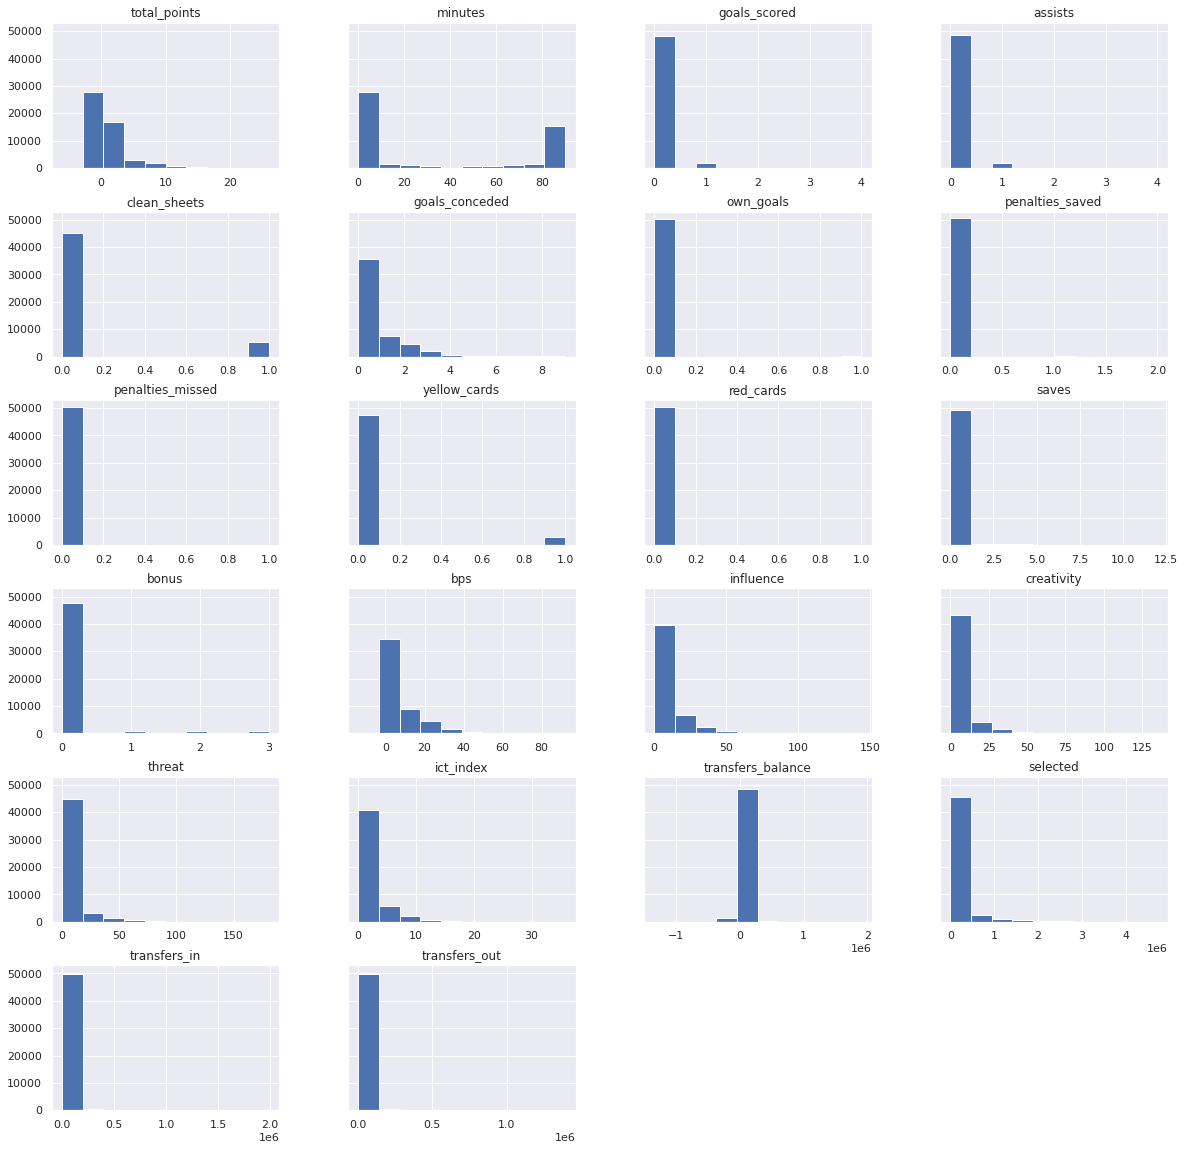

In [60]:
# To do: Create a visual of continuous variables
df_numeric.hist(bins=10, sharey=True, figsize=(20, 20), layout=(6, 4));

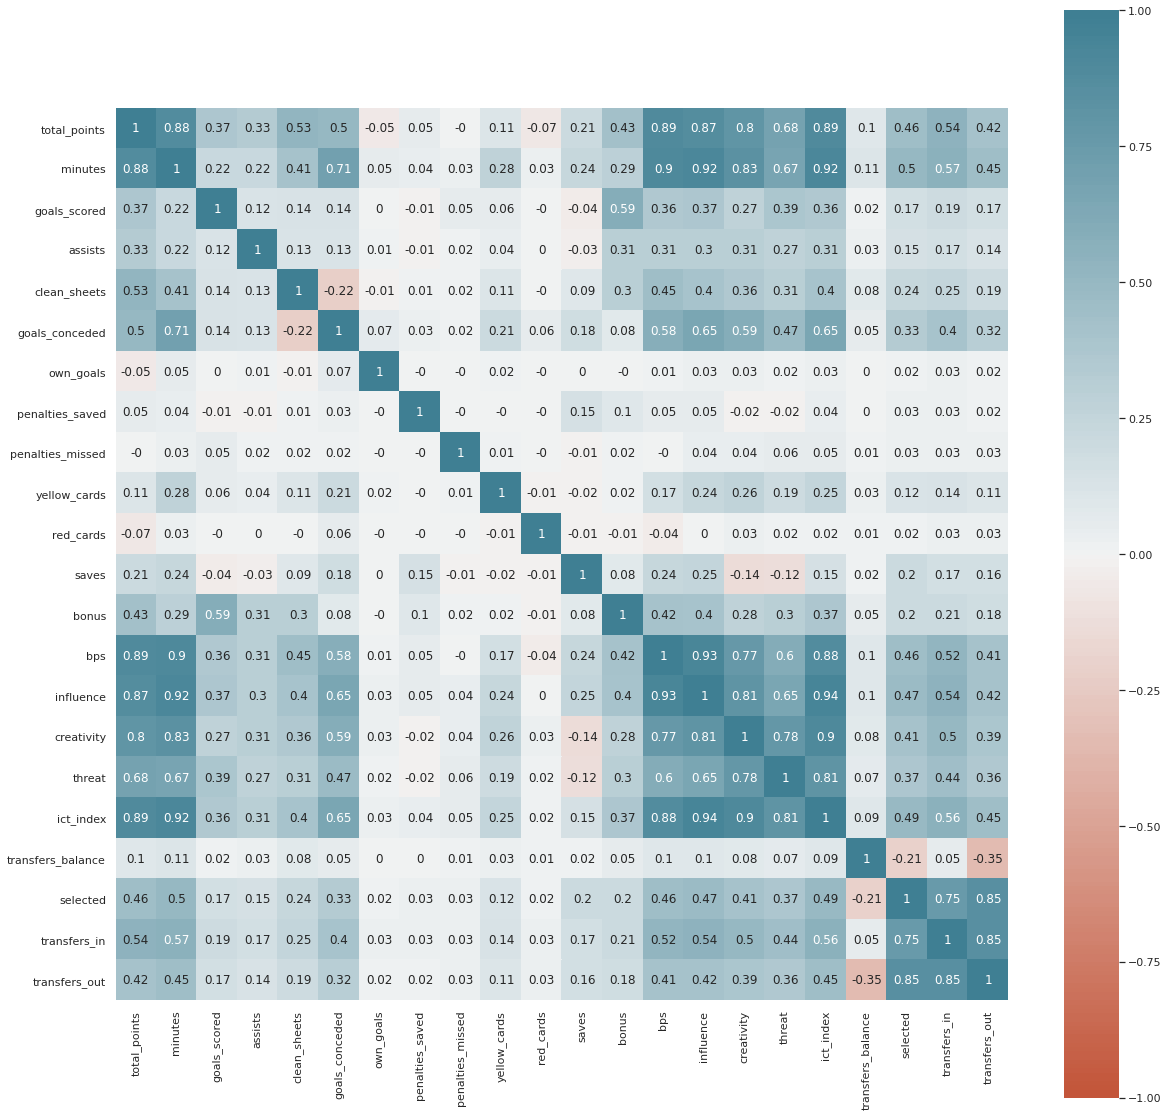

In [61]:
# Observe spearman correlation between variables
plt.figure(figsize=(20,20))
corr = df_numeric.corr(method='spearman').round(2)

_ = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)

plt.show()

In [62]:
#Checking frequency of 0 for each variable
df_0 = (df_numeric == 0).sum()

# Total for benchmark
df_count = df_numeric.count()

# Combining
df_0_count = pd.concat([df_0, df_count], axis=1)

# Renaming headings
df_0_count.columns = ['zero','count']

# Adding %
df_0_count['pct_zero'] = df_0_count['zero'] / df_0_count['count']

# Viewing
df_0_count

,zero,count,pct_zero
total_points,27592,50486,0.546528
minutes,26463,50486,0.524165
goals_scored,48401,50486,0.958701
assists,48540,50486,0.961455
clean_sheets,45138,50486,0.894070
goals_conceded,35570,50486,0.704552
own_goals,50407,50486,0.998435
penalties_saved,50449,50486,0.999267
penalties_missed,50437,50486,0.999029
yellow_cards,47668,50486,0.944183


In [63]:
# Defining an entropy calculation
def pandas_entropy(column):
  vc = pd.Series(column).value_counts()
  return entropy(vc)

In [64]:
# Applying entropy calculation to dataframe
df_0_count['entropy'] = df.apply(pandas_entropy, axis=0)
df_0_count

,zero,count,pct_zero,entropy
total_points,27592,50486,0.546528,1.552717
minutes,26463,50486,0.524165,1.831533
goals_scored,48401,50486,0.958701,0.188301
assists,48540,50486,0.961455,0.175058
clean_sheets,45138,50486,0.894070,0.337921
goals_conceded,35570,50486,0.704552,0.964977
own_goals,50407,50486,0.998435,0.011672
penalties_saved,50449,50486,0.999267,0.006114
penalties_missed,50437,50486,0.999029,0.007704
yellow_cards,47668,50486,0.944183,0.215301


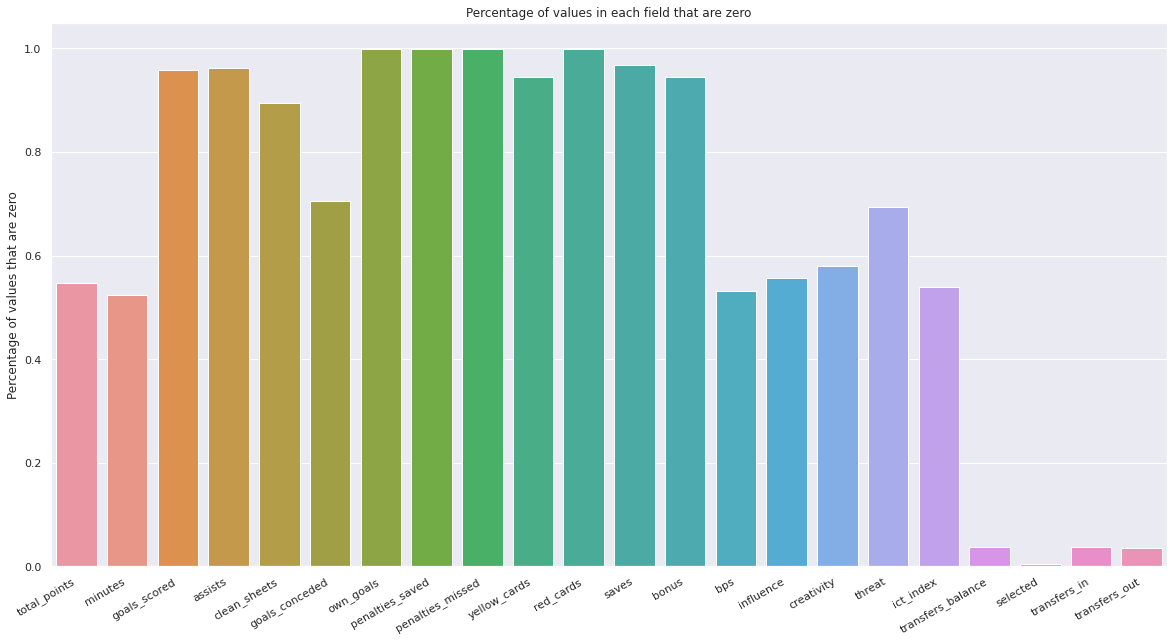

In [65]:
# Visualising 0s
plt.figure(figsize=(20,10))
g = sns.barplot(x = df_0_count.index, y="pct_zero", data=df_0_count)
g.set_xticklabels(g.get_xticklabels(),rotation=30,horizontalalignment='right')
g.set_ylabel('Percentage of values that are zero')
g.set_title("Percentage of values in each field that are zero")
plt.show()

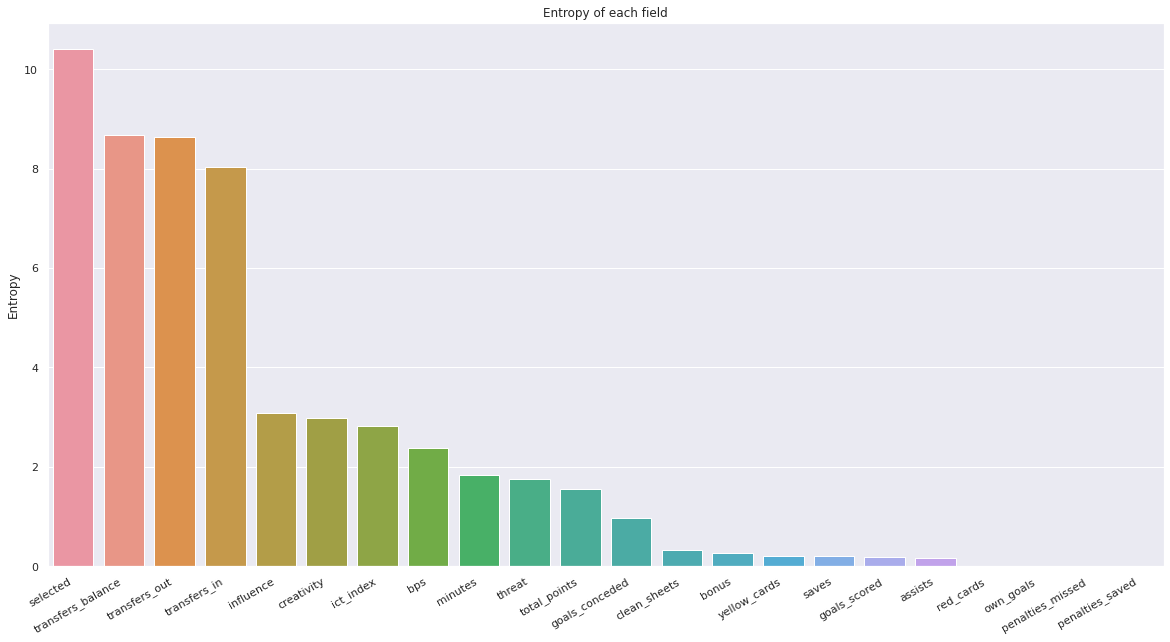

In [66]:
# Visualising 0s
plt.figure(figsize=(20,10))
df_0_sorted = df_0_count.sort_values(['entropy'],ascending=0)
g = sns.barplot(x = df_0_sorted.index, y="entropy", data=df_0_sorted)
g.set_xticklabels(g.get_xticklabels(),rotation=30,horizontalalignment='right')
g.set_ylabel('Entropy')
g.set_title("Entropy of each field")
plt.show()

# Feature engineering

## Transforming features based on exploratory analysis

In [67]:
# Updating data to remove variables and create a new cards variable
def num_cards(df):
    if df['red_cards'] == 1:
        return 2
    elif df['yellow_cards'] == 1:
        return 1
    else:
        return 0

df['cards'] = df.apply(num_cards, axis = 1)

df.head()

,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,round,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out,element_type,position,opponent_strength,season,cards
0,402,5,12,0,False,2018-08-12T12:30:00Z,4.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,55,0,103396,0,0,2,DEF,5,2018,0
1,402,250,12,2,True,2019-02-04T20:00:00Z,1.0,1.0,25,90,0,0,0,1,0,0,0,0,0,0,0,7,7.6,0.6,10.0,1.8,50,-787,32970,27,814,2,DEF,5,2018,0
2,145,15,12,-2,True,2018-08-20T19:00:00Z,0.0,2.0,2,74,0,0,0,2,0,0,0,0,1,0,0,-1,12.4,12.3,4.0,2.9,41,282492,1110097,296156,13664,2,DEF,5,2018,2
3,145,225,12,0,False,2019-01-19T15:00:00Z,4.0,3.0,23,90,0,0,0,4,0,0,0,0,0,0,0,15,17.8,0.8,0.0,1.9,45,21257,2025265,76053,54796,2,DEF,5,2018,0
4,386,128,12,1,True,2018-11-24T15:00:00Z,0.0,3.0,13,90,0,0,0,3,0,0,0,0,0,0,0,12,11.8,19.9,0.0,3.2,43,-768,6017,166,934,2,DEF,5,2018,0


In [68]:
# Transforming transfer variables
df['transfers_in_ratio'] = df['transfers_in'] / df['selected']
df['transfers_out_ratio'] = df['transfers_out'] / df['selected']

## Creating rolling and lag variables

In [69]:
# Sorting data before creating lag features
df_sorted = df.sort_values(by=['season','element','round','fixture'],ascending=True)
df_sorted.head()

,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,round,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out,element_type,position,opponent_strength,season,cards,transfers_in_ratio,transfers_out_ratio
14145,1,1,13,3,True,2018-08-12T15:00:00Z,0.0,2.0,1,90,0,0,0,2,0,0,0,0,0,6,0,24,47.0,0.0,0.0,4.7,50,0,70767,0,0,1,GKP,5,2018,0,0.000000,0.000000
6506,1,14,6,3,False,2018-08-18T16:30:00Z,3.0,2.0,2,90,0,0,0,3,0,0,0,0,0,8,0,26,53.0,0.0,0.0,5.3,50,188,90038,6059,5871,1,GKP,4,2018,0,0.067294,0.065206
21748,1,21,19,3,True,2018-08-25T14:00:00Z,3.0,1.0,3,90,0,0,0,1,0,0,0,0,0,4,0,17,27.8,0.0,0.0,2.8,50,8540,107301,19550,11010,1,GKP,3,2018,0,0.182198,0.102609
16314,1,33,5,1,False,2018-09-02T12:30:00Z,2.0,3.0,4,90,0,0,0,2,0,0,0,0,0,1,0,8,2.4,0.0,0.0,0.2,50,9582,123566,19332,9750,1,GKP,2,2018,0,0.156451,0.078905
15231,1,46,15,2,False,2018-09-15T14:00:00Z,1.0,2.0,5,90,0,0,0,1,0,0,0,0,0,1,0,13,14.2,0.0,0.0,1.4,50,-3297,123310,8837,12134,1,GKP,3,2018,0,0.071665,0.098402


In [70]:
# Appending points lag features for testing

df_sorted['points_lag_1'] = df_sorted.groupby(['season','element'])['total_points'].shift(1)
df_sorted['points_lag_2'] = df_sorted.groupby(['season','element'])['total_points'].shift(2)
df_sorted['points_lag_3'] = df_sorted.groupby(['season','element'])['total_points'].shift(3)
df_sorted['points_lag_4'] = df_sorted.groupby(['season','element'])['total_points'].shift(4)
df_sorted['points_lag_5'] = df_sorted.groupby(['season','element'])['total_points'].shift(5)
df_sorted['points_lag_6'] = df_sorted.groupby(['season','element'])['total_points'].shift(6)
df_sorted['points_lag_7'] = df_sorted.groupby(['season','element'])['total_points'].shift(7)
df_sorted['points_lag_8'] = df_sorted.groupby(['season','element'])['total_points'].shift(8)
df_sorted['points_lag_9'] = df_sorted.groupby(['season','element'])['total_points'].shift(9)
df_sorted['points_lag_10'] = df_sorted.groupby(['season','element'])['total_points'].shift(10)

df_sorted.head()

,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,round,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out,element_type,position,opponent_strength,season,cards,transfers_in_ratio,transfers_out_ratio,points_lag_1,points_lag_2,points_lag_3,points_lag_4,points_lag_5,points_lag_6,points_lag_7,points_lag_8,points_lag_9,points_lag_10
14145,1,1,13,3,True,2018-08-12T15:00:00Z,0.0,2.0,1,90,0,0,0,2,0,0,0,0,0,6,0,24,47.0,0.0,0.0,4.7,50,0,70767,0,0,1,GKP,5,2018,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6506,1,14,6,3,False,2018-08-18T16:30:00Z,3.0,2.0,2,90,0,0,0,3,0,0,0,0,0,8,0,26,53.0,0.0,0.0,5.3,50,188,90038,6059,5871,1,GKP,4,2018,0,0.067294,0.065206,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21748,1,21,19,3,True,2018-08-25T14:00:00Z,3.0,1.0,3,90,0,0,0,1,0,0,0,0,0,4,0,17,27.8,0.0,0.0,2.8,50,8540,107301,19550,11010,1,GKP,3,2018,0,0.182198,0.102609,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16314,1,33,5,1,False,2018-09-02T12:30:00Z,2.0,3.0,4,90,0,0,0,2,0,0,0,0,0,1,0,8,2.4,0.0,0.0,0.2,50,9582,123566,19332,9750,1,GKP,2,2018,0,0.156451,0.078905,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15231,1,46,15,2,False,2018-09-15T14:00:00Z,1.0,2.0,5,90,0,0,0,1,0,0,0,0,0,1,0,13,14.2,0.0,0.0,1.4,50,-3297,123310,8837,12134,1,GKP,3,2018,0,0.071665,0.098402,1.0,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
# Selecting only lag variables and removing NA
df_points = df_sorted[df_sorted.points_lag_10.notna()].copy()

df_points = df_points[['total_points','points_lag_1','points_lag_2'
,'points_lag_3','points_lag_4','points_lag_5','points_lag_6'
,'points_lag_7','points_lag_8','points_lag_9','points_lag_10']]

df_points.head(5)

,total_points,points_lag_1,points_lag_2,points_lag_3,points_lag_4,points_lag_5,points_lag_6,points_lag_7,points_lag_8,points_lag_9,points_lag_10
1051,0,0.0,0.0,0.0,1.0,11.0,2.0,1.0,3.0,3.0,3.0
4343,0,0.0,0.0,0.0,0.0,1.0,11.0,2.0,1.0,3.0,3.0
2155,0,0.0,0.0,0.0,0.0,0.0,1.0,11.0,2.0,1.0,3.0
9767,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,11.0,2.0,1.0
7586,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,11.0,2.0


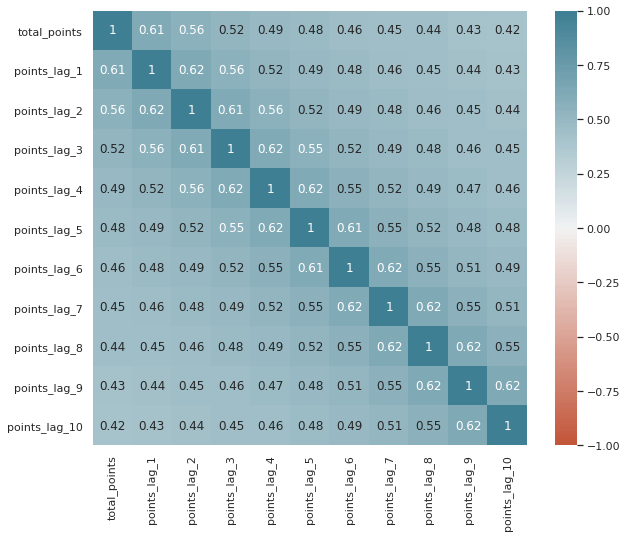

In [72]:
# Checking spearman correlation between points and lag variables
corr = df_points.corr(method='spearman')

_ = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)

plt.show()

In [73]:
# Iterate through columns to calculate partial correlations using linear regression

df_pcorr = pd.DataFrame()
df_covar = []

for i in df_points.drop('total_points',axis=1).columns:
  df_pcorr = df_pcorr.append(pg.partial_corr(data=df_points, x=i, y='total_points', covar=df_covar,
                method='spearman'))
  df_covar.append(i)

df_pcorr['lag_variable'] = df_covar
df_pcorr

,n,r,CI95%,r2,adj_r2,p-val,power,lag_variable
spearman,32052,0.614821,"[0.61, 0.62]",0.378005,0.377966,0.000000e+00,1.0,points_lag_1
spearman,32052,0.323941,"[0.31, 0.33]",0.104938,0.104882,0.000000e+00,1.0,points_lag_2
spearman,32052,0.214360,"[0.2, 0.22]",0.045950,0.045891,0.000000e+00,1.0,points_lag_3
spearman,32052,0.148561,"[0.14, 0.16]",0.022070,0.022009,1.429751e-157,1.0,points_lag_4
spearman,32052,0.145893,"[0.14, 0.16]",0.021285,0.021224,5.666327e-152,1.0,points_lag_5
spearman,32052,0.132739,"[0.12, 0.14]",0.017620,0.017558,6.399041e-126,1.0,points_lag_6
spearman,32052,0.121270,"[0.11, 0.13]",0.014706,0.014645,2.846320e-105,1.0,points_lag_7
spearman,32052,0.107605,"[0.1, 0.12]",0.011579,0.011517,3.652063e-83,1.0,points_lag_8
spearman,32052,0.105993,"[0.1, 0.12]",0.011234,0.011173,9.838224e-81,1.0,points_lag_9
spearman,32052,0.107443,"[0.1, 0.12]",0.011544,0.011482,6.423271e-83,1.0,points_lag_10


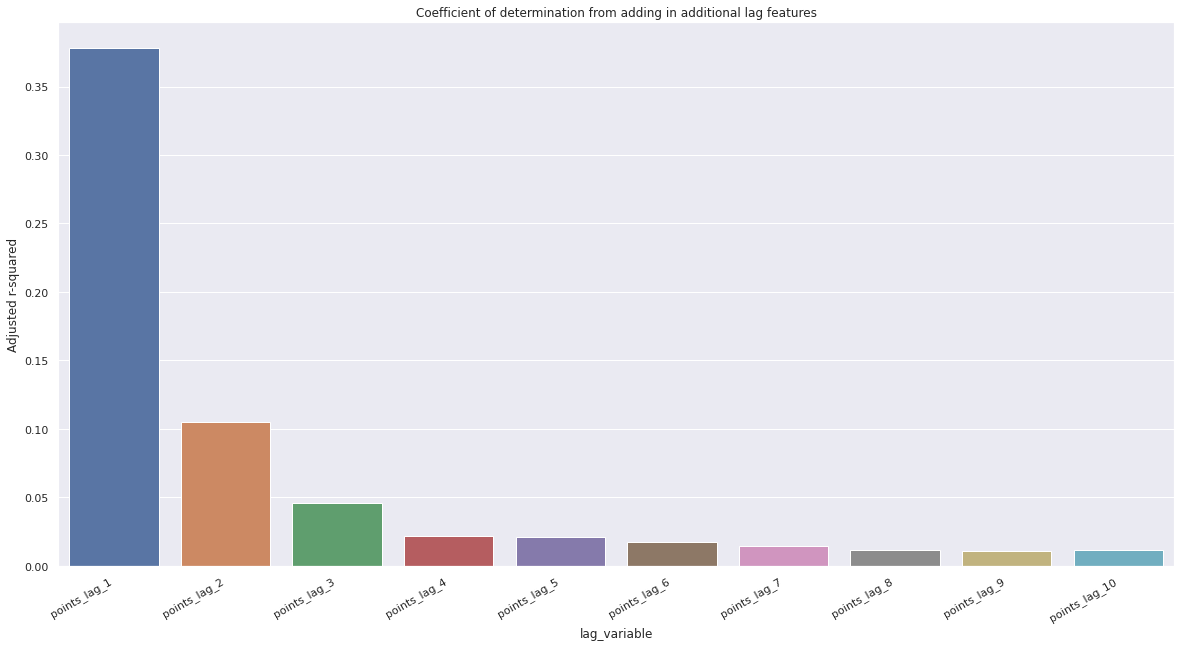

In [74]:
# Visualising partial correlations
plt.figure(figsize=(20,10))
g = sns.barplot(x="lag_variable", y="adj_r2", data=df_pcorr)
g.set_xticklabels(g.get_xticklabels(),rotation=30,horizontalalignment='right')
g.set_ylabel('Adjusted r-squared')
g.set_title("Coefficient of determination from adding in additional lag features")
plt.show()

In [75]:
df_sorted.head()

,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,round,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out,element_type,position,opponent_strength,season,cards,transfers_in_ratio,transfers_out_ratio,points_lag_1,points_lag_2,points_lag_3,points_lag_4,points_lag_5,points_lag_6,points_lag_7,points_lag_8,points_lag_9,points_lag_10
14145,1,1,13,3,True,2018-08-12T15:00:00Z,0.0,2.0,1,90,0,0,0,2,0,0,0,0,0,6,0,24,47.0,0.0,0.0,4.7,50,0,70767,0,0,1,GKP,5,2018,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6506,1,14,6,3,False,2018-08-18T16:30:00Z,3.0,2.0,2,90,0,0,0,3,0,0,0,0,0,8,0,26,53.0,0.0,0.0,5.3,50,188,90038,6059,5871,1,GKP,4,2018,0,0.067294,0.065206,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21748,1,21,19,3,True,2018-08-25T14:00:00Z,3.0,1.0,3,90,0,0,0,1,0,0,0,0,0,4,0,17,27.8,0.0,0.0,2.8,50,8540,107301,19550,11010,1,GKP,3,2018,0,0.182198,0.102609,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16314,1,33,5,1,False,2018-09-02T12:30:00Z,2.0,3.0,4,90,0,0,0,2,0,0,0,0,0,1,0,8,2.4,0.0,0.0,0.2,50,9582,123566,19332,9750,1,GKP,2,2018,0,0.156451,0.078905,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15231,1,46,15,2,False,2018-09-15T14:00:00Z,1.0,2.0,5,90,0,0,0,1,0,0,0,0,0,1,0,13,14.2,0.0,0.0,1.4,50,-3297,123310,8837,12134,1,GKP,3,2018,0,0.071665,0.098402,1.0,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
# Appending lag features for other variables

df_features = df_sorted.copy()
df_test = df_sorted.copy()

variables_to_lag = ['minutes','goals_scored','assists','clean_sheets'
,'goals_conceded','saves','cards','bonus','bps','influence','creativity'
,'threat','selected','transfers_in_ratio','transfers_out_ratio']

for i in variables_to_lag:
  lag_var = i + str("_lag")
  rolling_var = i + str("_rolling")
  df_features[lag_var] = df_features.groupby(['season','element'])[i].shift(1)
  df_features[rolling_var] = df_features.groupby(['season','element'])[lag_var].rolling(5).mean().values

df_features.head()

,element,fixture,opponent_team,total_points,was_home,kickoff_time,team_h_score,team_a_score,round,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out,element_type,position,opponent_strength,season,cards,transfers_in_ratio,transfers_out_ratio,points_lag_1,points_lag_2,points_lag_3,points_lag_4,points_lag_5,points_lag_6,points_lag_7,points_lag_8,points_lag_9,points_lag_10,minutes_lag,minutes_rolling,goals_scored_lag,goals_scored_rolling,assists_lag,assists_rolling,clean_sheets_lag,clean_sheets_rolling,goals_conceded_lag,goals_conceded_rolling,saves_lag,saves_rolling,cards_lag,cards_rolling,bonus_lag,bonus_rolling,bps_lag,bps_rolling,influence_lag,influence_rolling,creativity_lag,creativity_rolling,threat_lag,threat_rolling,selected_lag,selected_rolling,transfers_in_ratio_lag,transfers_in_ratio_rolling,transfers_out_ratio_lag,transfers_out_ratio_rolling
14145,1,1,13,3,True,2018-08-12T15:00:00Z,0.0,2.0,1,90,0,0,0,2,0,0,0,0,0,6,0,24,47.0,0.0,0.0,4.7,50,0,70767,0,0,1,GKP,5,2018,0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6506,1,14,6,3,False,2018-08-18T16:30:00Z,3.0,2.0,2,90,0,0,0,3,0,0,0,0,0,8,0,26,53.0,0.0,0.0,5.3,50,188,90038,6059,5871,1,GKP,4,2018,0,0.067294,0.065206,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,2.0,NaN,6.0,NaN,0.0,NaN,0.0,NaN,24.0,NaN,47.0,NaN,0.0,NaN,0.0,NaN,70767.0,NaN,0.000000,NaN,0.000000,NaN
21748,1,21,19,3,True,2018-08-25T14:00:00Z,3.0,1.0,3,90,0,0,0,1,0,0,0,0,0,4,0,17,27.8,0.0,0.0,2.8,50,8540,107301,19550,11010,1,GKP,3,2018,0,0.182198,0.102609,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,3.0,NaN,8.0,NaN,0.0,NaN,0.0,NaN,26.0,NaN,53.0,NaN,0.0,NaN,0.0,NaN,90038.0,NaN,0.067294,NaN,0.065206,NaN
16314,1,33,5,1,False,2018-09-02T12:30:00Z,2.0,3.0,4,90,0,0,0,2,0,0,0,0,0,1,0,8,2.4,0.0,0.0,0.2,50,9582,123566,19332,9750,1,GKP,2,2018,0,0.156451,0.078905,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,1.0,NaN,4.0,NaN,0.0,NaN,0.0,NaN,17.0,NaN,27.8,NaN,0.0,NaN,0.0,NaN,107301.0,NaN,0.182198,NaN,0.102609,NaN
15231,1,46,15,2,False,2018-09-15T14:00:00Z,1.0,2.0,5,90,0,0,0,1,0,0,0,0,0,1,0,13,14.2,0.0,0.0,1.4,50,-3297,123310,8837,12134,1,GKP,3,2018,0,0.071665,0.098402,1.0,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,90.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,2.0,NaN,1.0,NaN,0.0,NaN,0.0,NaN,8.0,NaN,2.4,NaN,0.0,NaN,0.0,NaN,123566.0,NaN,0.156451,NaN,0.078905,NaN


## Outputting data for model

In [130]:
#Downloading dataset
df_features.to_csv('fpl_features.csv',index=False) 
files.download('fpl_features.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File downloaded to local machine and uploaded to GitHub